# Pearson Residual Normalization on Zebrafish data

This tutorial uses data from [Saunders, et al (2019)](https://elifesciences.org/articles/45181). Special thanks also go to [Lauren](https://twitter.com/LSaund11) for the tutorial improvement. 

In this [study](https://elifesciences.org/articles/45181), the authors profiled thousands of neural crest-derived cells from trunks of post-embryonic zebrafish. These cell classes include pigment cells, multipotent pigment cell progenitors, peripheral neurons, Schwann cells, chromaffin cells and others. These cells were collected during an active period of post-embryonic development, which has many similarities to fetal and neonatal development in mammals, when many of these cell types are migrating and differentiating as the animal transitions into its adult form. This study also explores the role of thyroid hormone (TH), a common endocrine factor, on the development of these different cell types. 

Such developmental and other dynamical processes are especially suitable for dynamo analysis as dynamo is designed to accurately estimate direction and magnitude of expression dynamics (`RNA velocity`), predict the entire lineage trajectory of any intial cell state (`vector field`), characterize the structure (`vector field topology`) of full gene expression space, as well as fate commitment potential (`single cell potential`). 

Import the package and silence some warning information (mostly `is_categorical_dtype` warning from anndata)

In [1]:
import warnings
warnings.filterwarnings('ignore')

import dynamo as dyn 
from dynamo.configuration import DKM
import numpy as np
celltype_key = "Cell_type"

this is like R's sessionInfo() which helps you to debug version related bugs if any. 

## Load data

In [2]:
import scipy
from scipy.sparse import issparse, csr_matrix

adata = dyn.sample_data.zebrafish()
# adata.X = adata.layers["spliced"].copy()
# adata.X = csr_matrix(adata.X)
adata_origin = dyn.sample_data.zebrafish()

|-----> Downloading data to ./data/zebrafish.h5ad
|-----> Downloading data to ./data/zebrafish.h5ad


## Apply pearson residual normalization on different layers according `select_genes_key`. We may use other select_genes function combined with pearson residual normalization.

In [3]:
# adata = dyn.sample_data.zebrafish()
from dynamo.preprocessing import Preprocessor
import pearson_residual_normalization_recipe
from benchmark_utils import *
preprocessor = Preprocessor()
preprocessor.config_monocle_recipe(adata)
preprocessor.filter_cells_by_outliers = None
preprocessor.filter_genes_by_outliers = None
preprocessor.normalize_by_cells = None
preprocessor.select_genes_function = pearson_residual_normalization_recipe.select_genes_by_pearson_residual
preprocessor.normalize_selected_genes_function = pearson_residual_normalization_recipe.normalize_layers_pearson_residuals
# preprocessor.use_log1p = True
# preprocessor.preprocess_adata(adata)

preprocessor.select_genes_function(adata, n_top_genes=2000)
print(describe_mat(adata.X))
preprocessor.normalize_selected_genes_function(adata)
print(describe_mat(adata.X))
preprocessor.pca(adata, pca_key="X_pca",n_pca_components=50)


|-----------> <insert> {} to uns['pp'] in AnnData Object.
|-----> gene selection on layer: X
|-----> extracting highly variable genes
|-----> applying Pearson residuals to layer <X>


count    4.166246e+06
mean     2.933080e+00
std      7.640573e+00
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      2.000000e+00
max      9.980000e+02
dtype: float64


|-----> replacing layer <X> with pearson residual normalized data.
|-----> [pearson residual normalization] in progress: 100.0000%
|-----> [pearson residual normalization] finished [1.3360s]
|-----> applying Pearson residuals to layer <spliced>
|-----> replacing layer <spliced> with pearson residual normalized data.
|-----> [pearson residual normalization] in progress: 100.0000%
|-----> [pearson residual normalization] finished [4.5640s]
|-----> applying Pearson residuals to layer <unspliced>
|-----> replacing layer <unspliced> with pearson residual normalized data.
|-----> [pearson residual normalization] in progress: 100.0000%
|-----> [pearson residual normalization] finished [3.7720s]


count    1.131108e+07
mean     4.164497e-01
std      1.969009e+00
min     -7.406888e+00
25%     -2.788494e-01
50%     -7.355421e-02
75%      1.000000e+00
max      5.840000e+02
dtype: float64


AnnData object with n_obs × n_vars = 4181 × 16940
    obs: 'split_id', 'sample', 'Size_Factor', 'condition', 'Cluster', 'Cell_type', 'umap_1', 'umap_2', 'batch'
    var: 'means', 'variances', 'residual_variances', 'highly_variable_rank', 'gene_highly_variable', 'use_for_pca'
    uns: 'pp', 'PCs', 'explained_variance_ratio_', 'pca_mean'
    obsm: 'X_pca'
    layers: 'spliced', 'unspliced'

In [4]:
np.save("dyn_env_Xpca.npy", adata.obsm["X_pca"])

In [5]:
import scanpy as sc
import dynamo as dyn

sc_adata = dyn.sample_data.zebrafish()
sc_adata.X = sc_adata.layers["spliced"]
sc.experimental.pp.recipe_pearson_residuals(sc_adata, n_comps=50, n_top_genes=2000)

|-----> Downloading data to ./data/zebrafish.h5ad


In [6]:
sc_adata

AnnData object with n_obs × n_vars = 4181 × 16940
    obs: 'split_id', 'sample', 'Size_Factor', 'condition', 'Cluster', 'Cell_type', 'umap_1', 'umap_2', 'batch'
    var: 'means', 'variances', 'residual_variances', 'highly_variable_rank', 'highly_variable'
    uns: 'hvg', 'pca', 'pearson_residuals_normalization'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'spliced', 'unspliced'

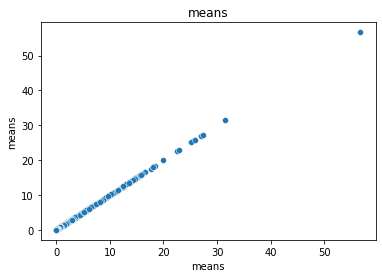

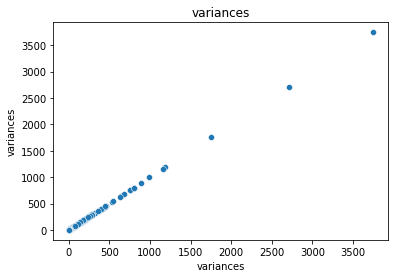

Text(0.5, 1.0, 'residual_variances')

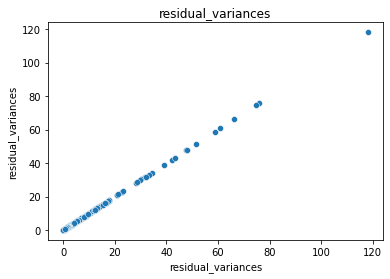

In [7]:
sns.scatterplot(adata.var["means"], sc_adata.var["means"]).set_title("means")
plt.show()
plt.clf()
sns.scatterplot(adata.var["variances"], sc_adata.var["variances"]).set_title("variances")
plt.show()
plt.clf()
sns.scatterplot(adata.var["residual_variances"], sc_adata.var["residual_variances"]).set_title("residual_variances")





In [8]:
adata.uns["pp"]

{'tkey': None,
 'has_splicing': True,
 'has_labeling': False,
 'has_protein': False,
 'splicing_labeling': False,
 'experiment_type': 'conventional',
 'experiment_layers': ['X', 'spliced', 'unspliced'],
 'experiment_total_layers': None,
 'hvg': {'flavor': 'pearson_residuals', 'computed_on': 'adata.X'},
 'X_pearson_residuals_normalization_params': {'theta': 100,
  'clip': None,
  'layer': 'X'},
 'spliced_pearson_residuals_normalization_params': {'theta': 100,
  'clip': None,
  'layer': 'spliced'},
 'unspliced_pearson_residuals_normalization_params': {'theta': 100,
  'clip': None,
  'layer': 'unspliced'}}

In [9]:
print(describe_mat(adata_origin[:, adata.var["use_for_pca"]].X))
print(describe_mat(adata[:, adata.var["use_for_pca"]].X))
# print(describe_mat(adata.uns["pp"]["pearson_residuals_normalization"]["pearson_residuals_df"].to_numpy()))
print(describe_mat(sc_adata.uns["pearson_residuals_normalization"]["pearson_residuals_df"].to_numpy()))

count    1.217164e+06
mean     6.297184e+00
std      1.324103e+01
min      1.000000e+00
25%      1.000000e+00
50%      2.000000e+00
75%      6.000000e+00
max      9.980000e+02
dtype: float64
count    8.362000e+06
mean     1.856885e-02
std      1.843442e+00
min     -7.406888e+00
25%     -3.741466e-01
50%     -1.574537e-01
75%     -5.090857e-02
max      6.466065e+01
dtype: float64
count    8.362000e+06
mean     1.856881e-02
std      1.843442e+00
min     -7.406888e+00
25%     -3.741466e-01
50%     -1.574537e-01
75%     -5.090866e-02
max      6.466065e+01
dtype: float64


In [10]:
residuals = pearson_residual_normalization_recipe.compute_pearson_residuals(adata_origin[:, adata.var["use_for_pca"]].X, theta=100, clip=None, check_values=True,copy=False)
describe_mat(residuals)

count    8.362000e+06
mean     1.856885e-02
std      1.843442e+00
min     -7.406888e+00
25%     -3.741466e-01
50%     -1.574537e-01
75%     -5.090857e-02
max      6.466065e+01
dtype: float64

In [11]:
sc_adata

AnnData object with n_obs × n_vars = 4181 × 16940
    obs: 'split_id', 'sample', 'Size_Factor', 'condition', 'Cluster', 'Cell_type', 'umap_1', 'umap_2', 'batch'
    var: 'means', 'variances', 'residual_variances', 'highly_variable_rank', 'highly_variable'
    uns: 'hvg', 'pca', 'pearson_residuals_normalization'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'spliced', 'unspliced'

dyn X_pca shape: (4181, 50)
sc X_pca shape: (4181, 50)
#nonzeros in m1:209050, #nonzeros in m2:209050
dyn preprocessor adata.X stats:
count    1.131108e+07
mean     4.164497e-01
std      1.969009e+00
min     -7.406888e+00
25%     -2.788494e-01
50%     -7.355421e-02
75%      1.000000e+00
max      5.840000e+02
dtype: float64
original adata spliced stats:
count    4.166246e+06
mean     2.933080e+00
std      7.640573e+00
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      2.000000e+00
max      9.980000e+02
dtype: float64
original adata.X stats:
count    4.166246e+06
mean     2.933080e+00
std      7.640573e+00
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      2.000000e+00
max      9.980000e+02
dtype: float64
sc adata.X stats:
count    4.166246e+06
mean     2.933080e+00
std      7.640573e+00
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      2.000000e+00
max      9.980000e+02
dtype: float64
sc genes length: 2000
dyn prep

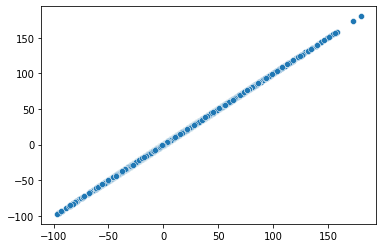

In [12]:
import pandas as pd
print("dyn X_pca shape:", adata.obsm["X_pca"].shape)
print("sc X_pca shape:", sc_adata.obsm["X_pca"].shape)

preprocess_genes = adata.var_names[adata.var[DKM.VAR_USE_FOR_PCA]]
sc_genes = sc_adata.var_names[sc_adata.var["highly_variable"]]

def benchmark_Xpca(adata, other_adata, key="X_pca"):
    plot_scatter_sparse(adata.obsm[key], other_adata.obsm[key])
benchmark_Xpca(adata, sc_adata)
print("dyn preprocessor adata.X stats:")
print(describe_mat(adata.X))
print("original adata spliced stats:")
print(describe_mat(adata_origin.layers["spliced"]))
print("original adata.X stats:")
print(describe_mat(adata_origin.X))
print("sc adata.X stats:")
print(describe_mat(sc_adata.X))



print("sc genes length:", len(sc_genes))
print("dyn preprocess genes:", len(preprocess_genes))
print("#different genes regarding highly variable genes:", len(set(sc_genes).difference(set(preprocess_genes))))
# assert not set(sc_genes).difference(set(preprocess_genes))
# assert not set(preprocess_genes).difference(set(sc_genes))

In [13]:
describe_mat(adata.obsm["X_pca"])

count    2.090500e+05
mean     2.744465e-08
std      7.850165e+00
min     -9.724918e+01
25%     -2.025148e+00
50%     -1.669224e-01
75%      1.591828e+00
max      1.802114e+02
dtype: float64

In [14]:
adata

AnnData object with n_obs × n_vars = 4181 × 16940
    obs: 'split_id', 'sample', 'Size_Factor', 'condition', 'Cluster', 'Cell_type', 'umap_1', 'umap_2', 'batch'
    var: 'means', 'variances', 'residual_variances', 'highly_variable_rank', 'gene_highly_variable', 'use_for_pca'
    uns: 'pp', 'PCs', 'explained_variance_ratio_', 'pca_mean'
    obsm: 'X_pca'
    layers: 'spliced', 'unspliced'

In [15]:
dyn.tl.reduceDimension(adata, basis="pca", reduction_method="umap")
dyn.pl.umap(adata, color=[celltype_key], figsize=(12, 12))


|-----> retrive data for non-linear dimension reduction...
|-----> perform umap...


In [ ]:
dyn.tl.leiden(adata, basis="pca")
dyn.pl.leiden(adata, basis="pca", color="Cell_type")
dyn.tl.louvain(adata, basis="pca")
dyn.pl.louvain(adata, basis="pca", color="Cell_type")

In [ ]:
adata.layers["X_spliced"] = adata.layers["spliced"]
adata.layers["X_unspliced"] = adata.layers["unspliced"] 
adata.uns["pp"]["norm_method"] = "" 
dyn.tl.dynamics(adata, model='stochastic', cores=3)
dyn.pl.streamline_plot(adata, color=[celltype_key], basis='umap', show_legend='on data', show_arrowed_spines=True)


In [ ]:
dyn.tl.reduceDimension(adata,basis="pca")
# dyn.pp.cell_cycle_scores(adata)
dyn.pl.umap(adata, color=["louvain", celltype_key], figsize=(12, 12))

In [ ]:
sc.pp.neighbors(sc_adata)
sc.tl.umap(sc_adata)
sc.pl.umap(sc_adata, color=celltype_key)